# LSTM + 

In [1]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn. preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output 

# Smatplotlib inline

sns.set(font_scale=1.3, palette='Set2')

In [2]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

В данном ноутбуке мы рассмотрим, как с помощью сверточных и рекурентных сетей предсказывать временные ряды.

# Предсказание временных рядов с помощью нейронных сетей

Скачаем даныне о максимальном спросе на электричество (Consumption) в штате Виктория (Австралия) за 30-минутные интервалы с 10 января 2000 в течении 115 дней, а так же информация о температуре воздуха (Temperature) за эти же промежутки времени.

In [3]:
!wget -O electricity.txt https://www.dropbox.com/s/am0x9o3jky2ni01/electricity.txt?dl=0

--2024-05-28 13:12:17--  https://www.dropbox.com/s/am0x9o3jky2ni01/electricity.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/am0x9o3jky2ni01/electricity.txt [following]
--2024-05-28 13:12:17--  https://www.dropbox.com/s/raw/am0x9o3jky2ni01/electricity.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9aab11a338a1db44bbe692e215.dl.dropboxusercontent.com/cd/0/inline/CTzFHZ_VEhE-6Sj0CljFVsXtTGP05JOWb82AuUeXpNB7SSjvipxfsyFec7smadlRGBn_UcRqi55H4AW4MbbmUdnaCTmqoePdt_Y0bl-dVcwy7Gv7HAowX11U459ripzXH4-JBr_FqGbWq1HpI-jAJuSf/file# [following]
--2024-05-28 13:12:18--  https://uc9aab11a338a1db44bbe692e215.dl.dropboxusercontent.com/cd/0/inline/CTzFHZ_VEhE-6Sj0CljFVsXtTGP05JOWb82AuUeXpNB7SSjvipxfsyFec7smadlRGBn_UcRqi55H4AW4MbbmU

In [4]:
df = pd.read_csv('electricity.txt', sep=',', index_col=0) 
df.drop(['DailySeasonality', 'WeeklySeasonality', 'Time'], axis=1, inplace=True) 
df.head ()

,Consumption,Temperature
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60


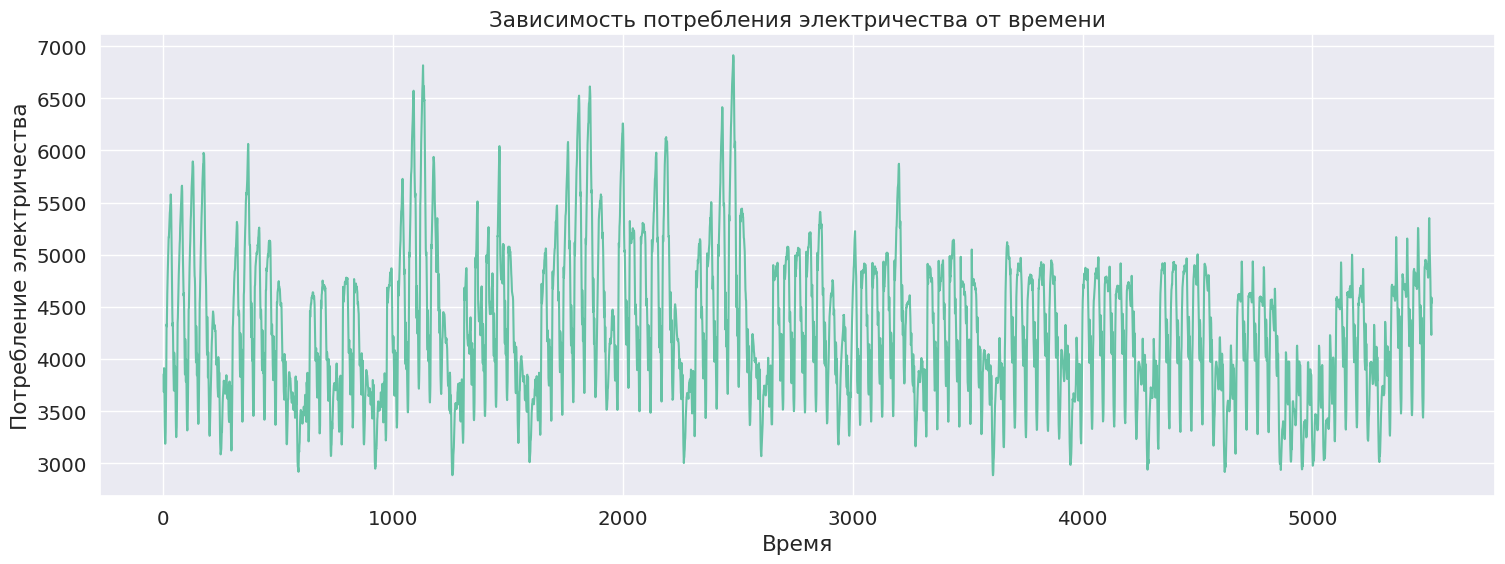

In [5]:
# Визуализируем данные

plt.figure(figsize=(18, 6))
plt.plot(df.index, df.Consumption)
plt.xlabel('Время')
plt.ylabel('Потребление электричества')
plt.title('Зависимость потребления электричества от времени') 
plt.show()

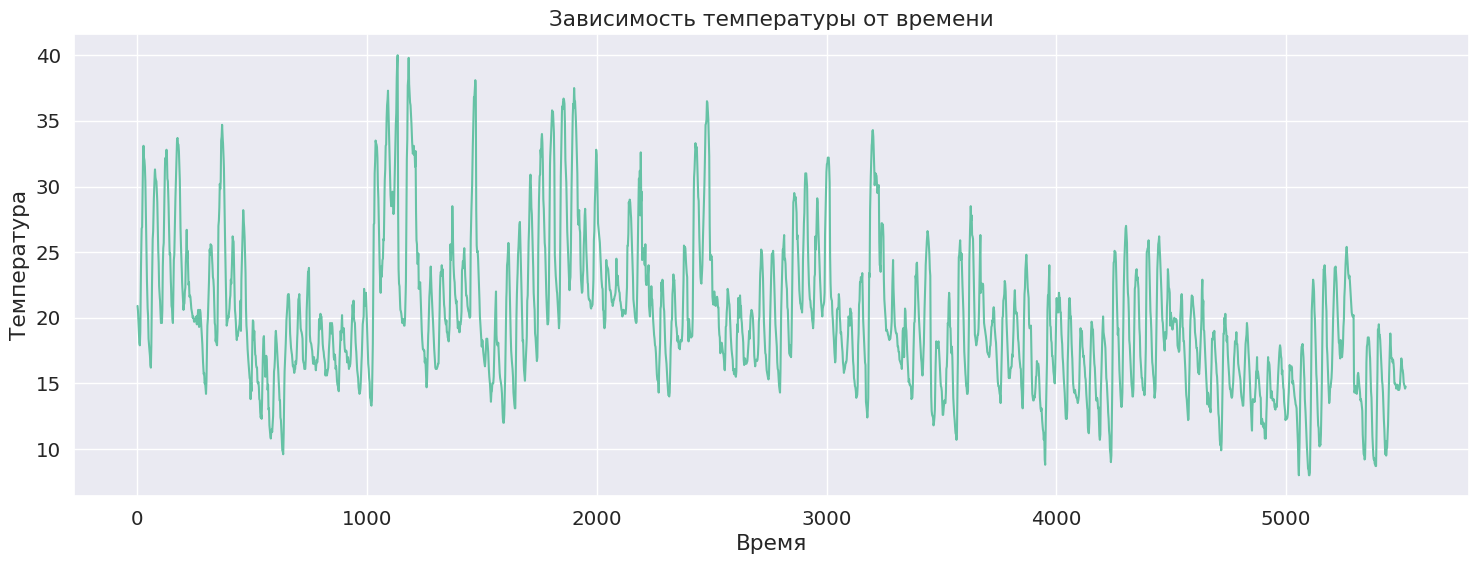

In [6]:
plt.figure(figsize=(18, 6))
plt.plot(df.index, df.Temperature)
plt.xlabel("Время")
plt.ylabel('Температура')
plt.title('Зависимость температуры от времени') 
plt.show()

Разобьём на временной ряд на обучающую и тестовую части. В качестве тестовой части возьмём данные за последнюю неделю
(последние 48*7 измерений).

Для предсказания потребления электричества в следующий день будем использовать потребление электричества и температуру в
предыдущие дни.

In [7]:
train_data = df[['Consumption', 'Temperature']][:-48*7] 
test_data = df[['Consumption', 'Temperature']][-48*7:]

train_data.head()

,Consumption,Temperature
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60


In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data_normalized = scaler.fit_transform(train_data) 
test_data_normalized = scaler.transform(test_data)

train_data_normalized

array([[-0.51917527, -0.19375   ],
       [-0.60383278, -0.20625   ],
       [-0.48994882, -0.21875   ],
       ...,
       [-0.46204343, -0.521875  ],
       [-0.28224873, -0.55      ],
       [-0.28877964, -0.578125  ]])

Обучение нейросети (сверточной и рекуррентной):

Предположим мы хотим обучать нейросеть, используя $\tau$ предыдущих измерений. 
Тогда каждую эпоху мы будем передавать сети батчи из последовательных отрезков временного ряда 
с индексами от $t - \tau + 1$ до $t$ 
и для каждого такого отрезка будем просить предсказать значение с индекcом $t + 1$, где $t$ - момент времени, $t > \tau - 1$.

Иначе говоря, нейронная сеть будет приближать функцию 
$$X_{t - \tau + 1}, ... , X_t \rightarrow X_{t+1}$$

Вычисление предсказаний:
* Возьмем $\tau$ последних обучающих данных и на их основе вычислим прогноз в первый момент времени тестового отрезка ряда. 
* Последующие прогнозы будем делать на основе предыдущих прогнозов, не используя значения из тестового отрезка ряда.

Для обучения нужно создать датасет, который будет возвращать последовательность 
из $\tau$ элементов временного ряда для обучения и следующий за ними $(\tau + 1)$-элемент как таргет. 
Для этого мы создадим класс-наследник от класса `Dataset` из `torch.utils.data`.

При наследовании от `Dataset` необходимо переопределить `＿len＿` и `＿getitem_`.

In [9]:
class TSDataset (Dataset) :
    
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past # tau -- длина отрезка временого ряда
    
    def __len__(self):
        return self.data.shape[0] - self.n_past
    
    def __getitem__(self, index) :
        return self.data[index: self.n_past + index], self.data[self.n_past + index]

Модель будет смотреть в прошлое на $\tau$ измерений. 
В данных одному дню соответствует 48 измерений, поэтому возьмем tau = 48.

In [10]:
n_past = 48 # tau -- длина отрезка временого ряда
batch_size = 16 # размер батча

train_dataset = TSDataset(train_data_normalized, n_past)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=False)

### Пайплайн обучения

In [11]:
def plot_learning_curves(history):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    :param history: (dict)
        accuracy и loss на обучении и валидации.
    """
    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.ylabel("Лосс")
    plt.xlabel("Эпоха")
    plt.show()

In [12]:
def evaluate_ts_model(model, start_seq, test_data):
    """
    Функция для проверки качества модели на обучающем отрезке ряда.
    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.
    
    :return: результаты предсказания.
    """
    result = []
    
    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0) 
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0) 
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append (logits.cpu() .numpy().squeeze()) 
    return result

In [13]:
def plot_ts_results(result, show_from=0, lw=2):
    """
    Визуализирует результаты прогнозирования
    :param result: прогнозы
    :param show_from: с какого момента визуализировать обучающие данные
    :param lw: толщина линии
    """
    fontsize = 16
    plt.figure(figsize = (18, 8))
    plt.title('Зависимость потребления электричества от времени')
    plt.plot(df.index[show_from:], df.Consumption[show_from:], label='Истина', lw=lw)
    plt.plot(df.index[-48*7:], result[:, 0], label="Предсказание", lw=lw)
    plt.xlabel("Время")
    plt.ylabel('Потребление электричества')
    plt.legend()
    plt.show()

In [14]:
def train_ts_model(model, criterion, optimizer, train_batch_gen, num_epochs=50):
    """
    Функция для обучения модели и вывода лосса во время обучения.
    :param model: обучаемая модель 
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param num epochs: количество эпоx
    
    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    """
    
    history = defaultdict(list)
    
    for epoch in range(num_epochs) :
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()
        
        # Устанавливаем поведение dropout / batch norm в обучение 
        model.train(True)
        
        # На каждой "эпохе" делаем полный проход по данным 
        for X_batch, y_batch in train_batch_gen:
            
            X_batch = X_batch.type('torch.FloatTensor').to(device)
            y_batch = y_batch.type('torch.FloatTensor').to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch)
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
        
        # Подсчитываем лосс и сохраням в 'историю' 
        train_loss /= len(train_batch_gen) 
        history['loss'].append(train_loss)
        
        clear_output()
        
        # Печатаем результаты после каждой эпохи
        print("Эпоха {} из {} выполнена за {:.3f} сек.".format(
            epoch + 1, num_epochs, time.time() - start_time)
        ) 
        print(" лосс: \t{:.6f}".format(train_loss))
        plot_learning_curves(history)
        
    return model, history

# 1. LSTM - прогнозирование временного ряда с помощью рекуррентных сетей

Напишем однослойную LSTM.

С помощью неё будем прогнозировать два значения: потребление электричества и температуру. 
При тестировании будем брать только спрогнозированное потребление.

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100): 
        super().__init__()
        
        self.hidden_size = hidden_size
        # input_seq.shape = [16, 48, 2]
        # lstm_out.shape = [16, 48, 100] 
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size, 
            batch_first=True
        )
        
        # hidden_state = [2, 16, 100]
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, input_seq):
        lstm_out, (hidden_state, _ ) = self.lstm(input_seq) 
        predictions = self.linear(hidden_state.squeeze(0)) 
        return predictions

In [16]:
# Объявляем модель
lstm_model = LSTM(
    input_size=2, # 2 признака: электричество и температура 
    output_size=2
)
lstm_model.to(device)
# lstm_model.type('torch.FloatTensor').to(device)
print(lstm_model)

LSTM(
  (lstm): LSTM(2, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)


Эпоха 80 из 80 выполнена за 1.354 сек.
 лосс: 	0.000533


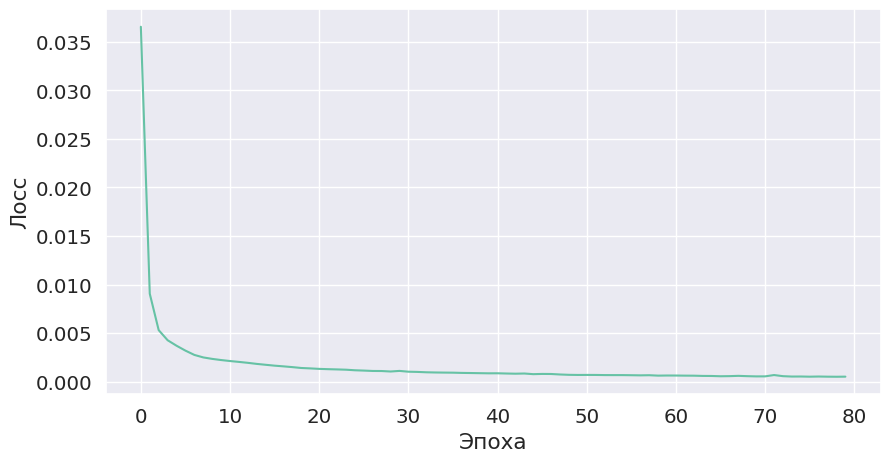

In [17]:
# И обучаем ее
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_model, _ = train_ts_model(lstm_model, criterion, optimizer, train_batch_gen, num_epochs=80);

In [18]:
# Получаем результаты на тестовых данных
start_seq = train_data_normalized[-n_past:] 
lstm_result = evaluate_ts_model(lstm_model, start_seq, test_data_normalized)

In [19]:
# Применяем обратное преобразование к результатам, чтобы убрать нормализацию

lstm_result = np.array(lstm_result, ndmin=2) 
lstm_result = scaler.inverse_transform(lstm_result)

In [20]:
# Подсчитываем ошибку предсказания потребления электричества
y_truth = test_data['Consumption']
rmse = np.sqrt(((lstm_result[:, 0] - y_truth) ** 2).mean())
print ("RMSE на тестовых данных {:3f}".format(rmse))

RMSE на тестовых данных 489.936484


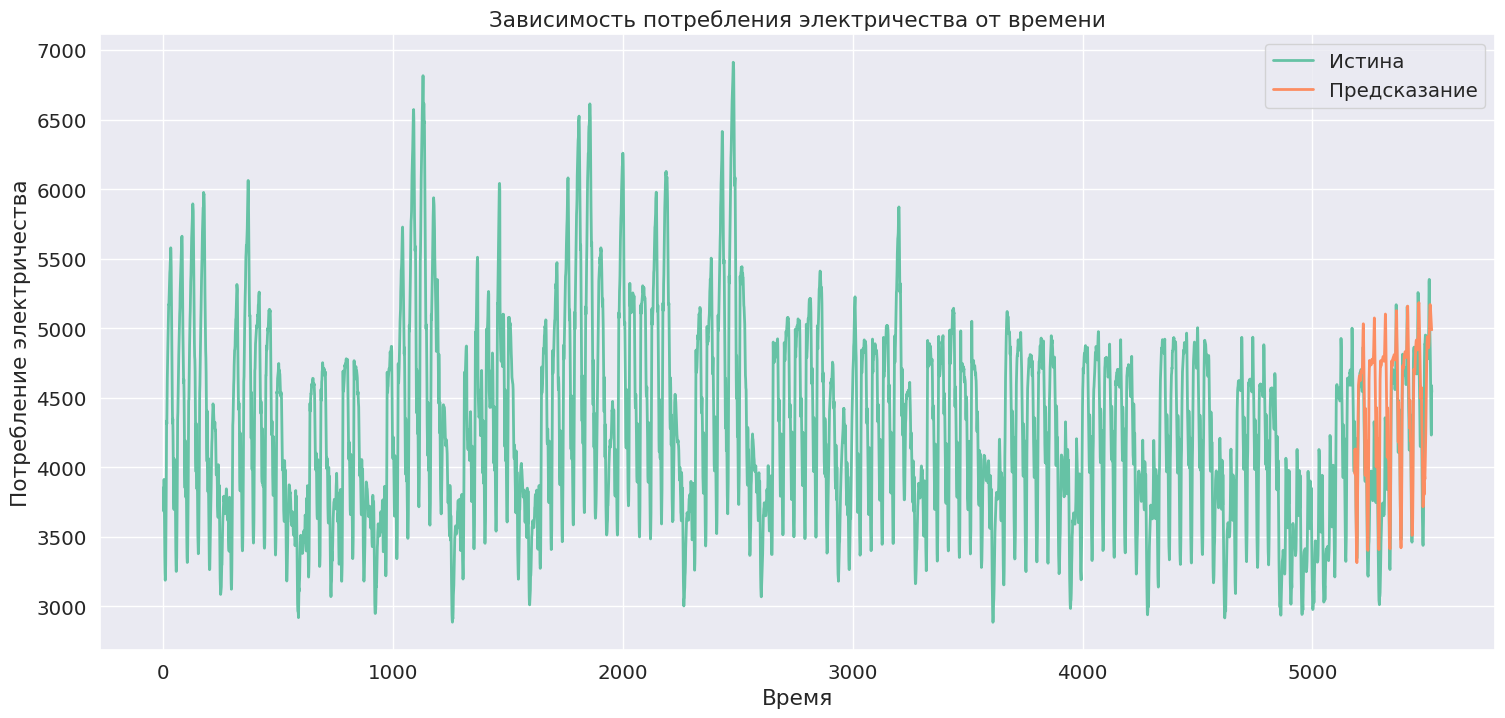

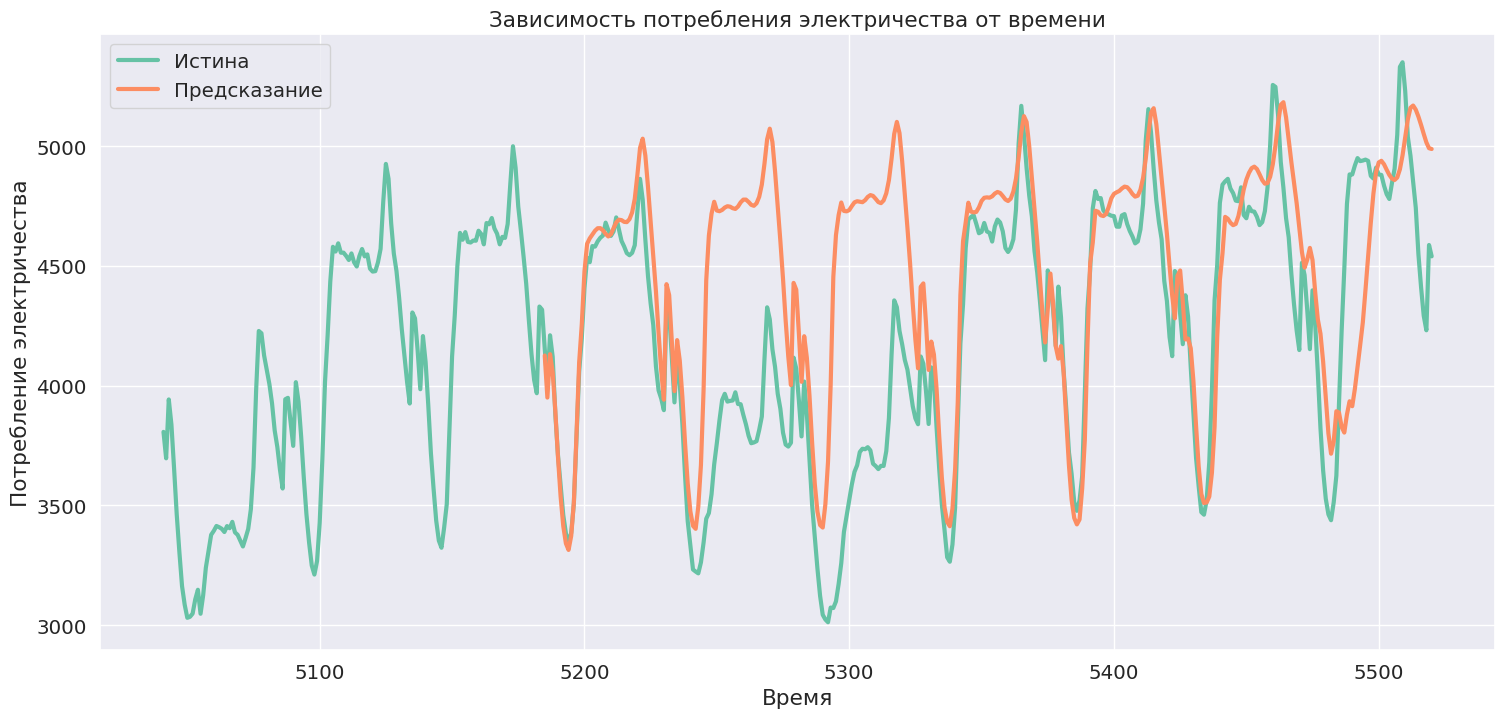

In [21]:
# Визуализируем результаты предсказания
plot_ts_results(lstm_result)
plot_ts_results(lstm_result, show_from=48*7*15, lw=3)

# 2. Cвертки Conv1d - прогнозирование временных рядов с помощью сверточных сетей.

Аналогично будем прогнозировать два значения: потребление электричества и температуру. 
При тестировании будем брать только спрогнозированное потребление.

Для реализации этой модели будем использовать Conv1d свертки по одной пространственной размерности - времени. \
В нашем случае данные состоят из последовательности $\tau$ векторов размерноти $2$, таким образом первая `Conv1d` будет проходить по двум
каналам по входу размера $\tau$.

Напишем сверточную сеть, состоящую из `Conv1d`, `BatchNorm1d`, `ReLU` и `Linear` слоёв.

In [40]:
class Conv1dModel (nn.Module):
    def __init__ (self, in_channels, output_size):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels=32, kernel_size=12, stride=2) 
        self.bn1 = nn.BatchNorm1d(num_features=32)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=output_size)
        
    def forward(self, input_seq) :
        #input_seq.shape = [16, 48, 2]
        #input_seq.shape = [16, 2, 48] 
        
        input_seq = input_seq.transpose(1,2)
        
        # x.shape = [16, 32, 19)
        x = self.relu1(self.bn1(self.conv1(input_seq)))
        
        # x.shape = [16, 64, 6]
        x = self.relu2(self.bn2(self.conv2(x)))
        
        # x.shape = [16, 128, 2]
        x = self.relu3(self.bn3(self.conv3(x)))
        
        # x.shape [16, 256]
        x = self.flatten(x)
        
        # x.shape = [16, 128]
        x = self.relu(self.fc1(x))
        
        # x.shape = [16, 21]
        x = self.fc2 (x)
        
        return x

In [41]:
# Объявим модели
conv_model = Conv1dModel(2, 2)
conv_model.to(device)

Conv1dModel(
  (conv1): Conv1d(2, 32, kernel_size=(12,), stride=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(8,), stride=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Эпоха 120 из 120 выполнена за 1.240 сек.
 лосс: 	0.001692


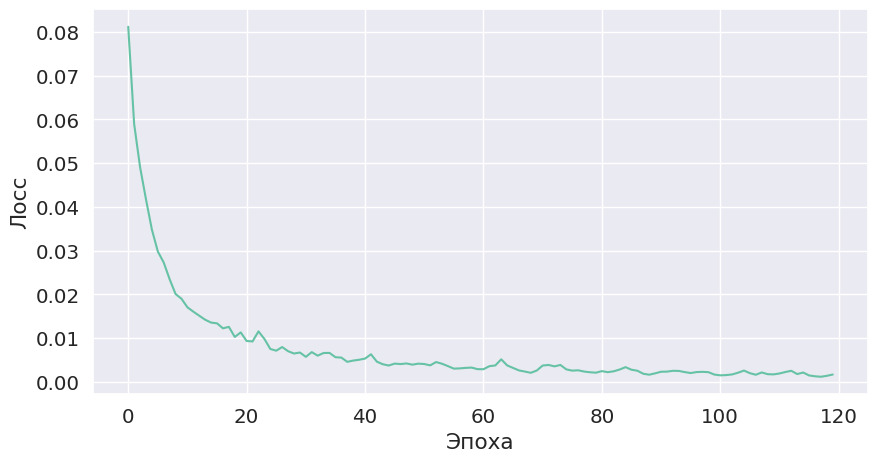

In [42]:
# Обучение модели
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model, _ = train_ts_model(conv_model, criterion, optimizer, train_batch_gen, num_epochs=120);

In [44]:
# Получаем результаты на тестовых данных
start_seq = train_data_normalized[-n_past:]
conv_result = evaluate_ts_model(conv_model, start_seq, test_data_normalized)

# Применяем обратное преобразование к результатам, чтобы убрать нормализацию
conv_result = np.array(conv_result, ndmin=2)
conv_result = scaler.inverse_transform(conv_result)

In [47]:
# Подсчитываем ошибку предсказания потребления электричества
y_truth = test_data['Consumption']
rmse = np.sqrt(((conv_result[:, 0] - y_truth)**2).mean())
print ("RMSE на тестовых данных {:.3f}".format(rmse))

RMSE на тестовых данных 567.048


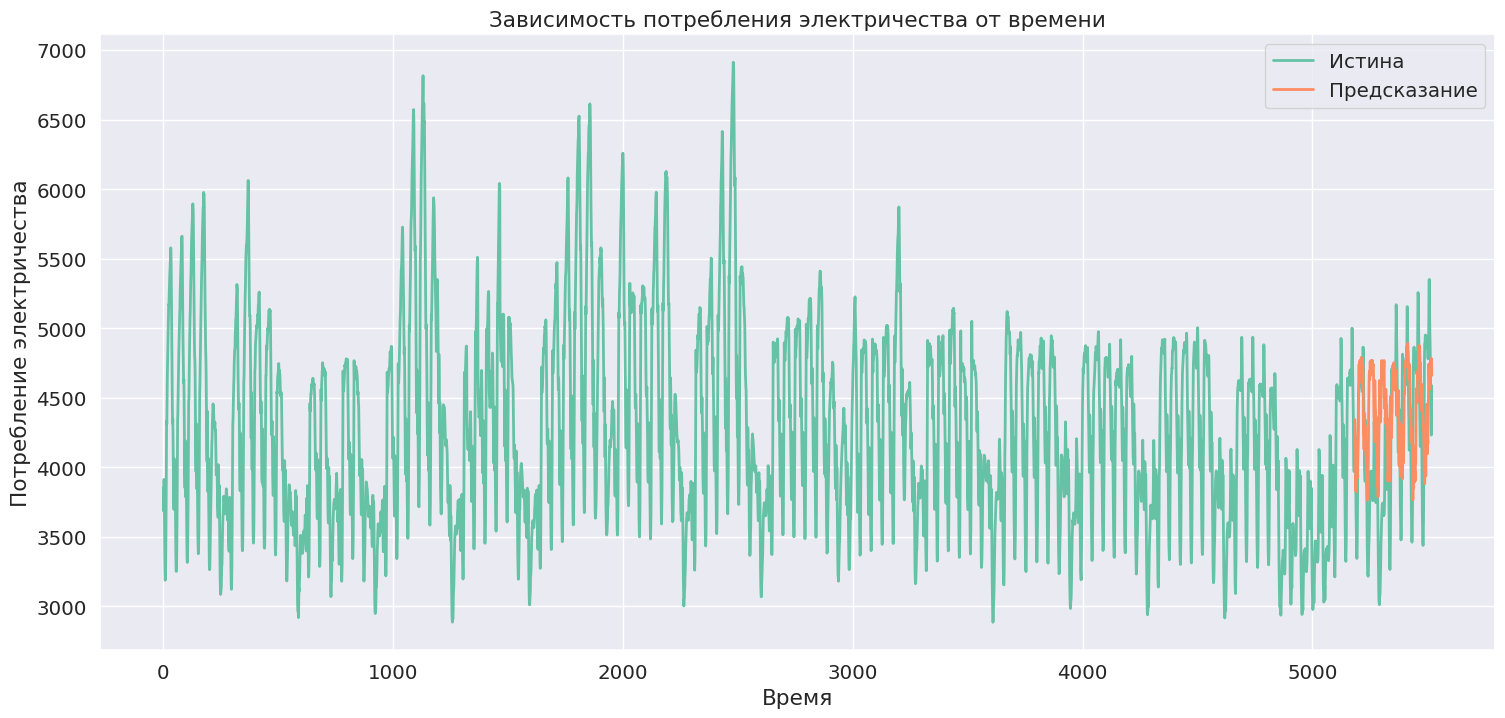

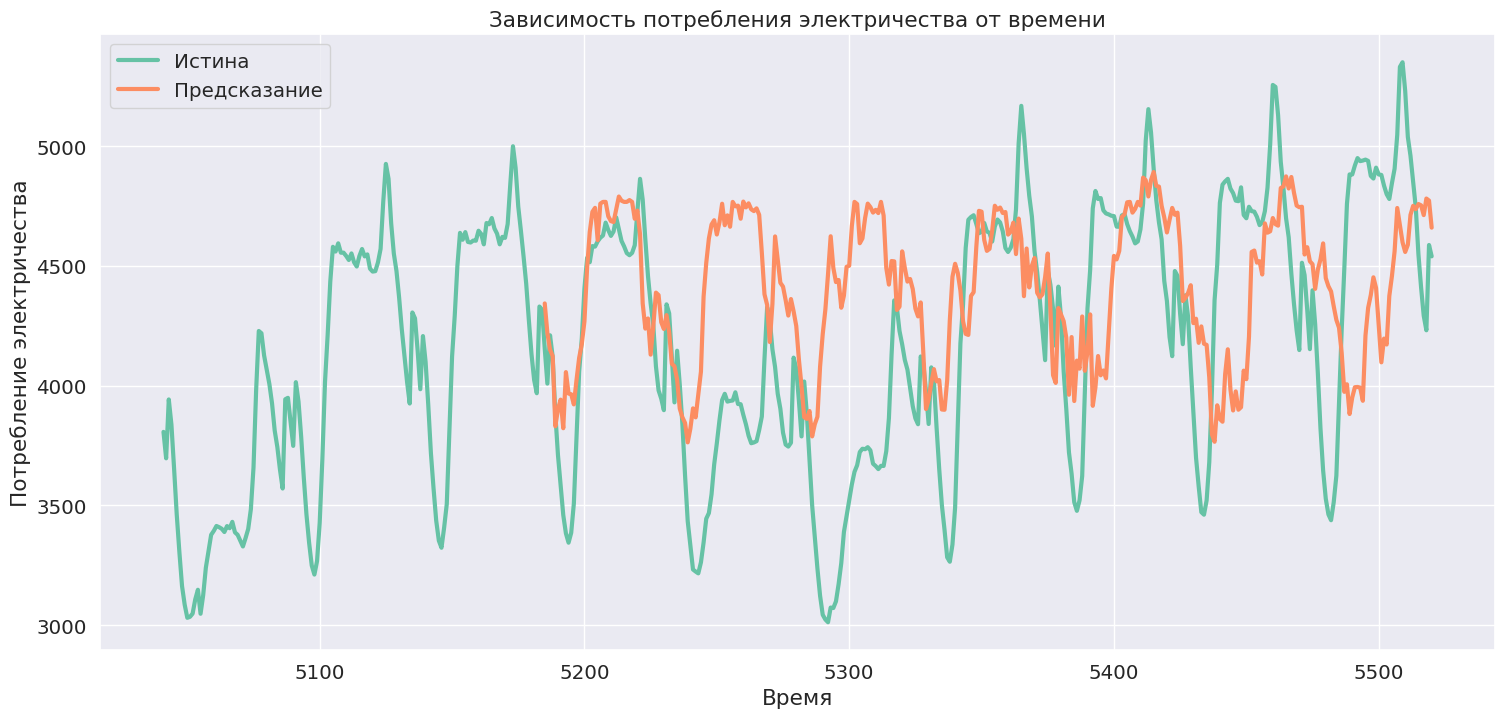

In [48]:
# Визуализируем результаты предсказания
plot_ts_results(conv_result)
plot_ts_results(conv_result, show_from=48*7*15, lw=3)

# Сравнение результатов

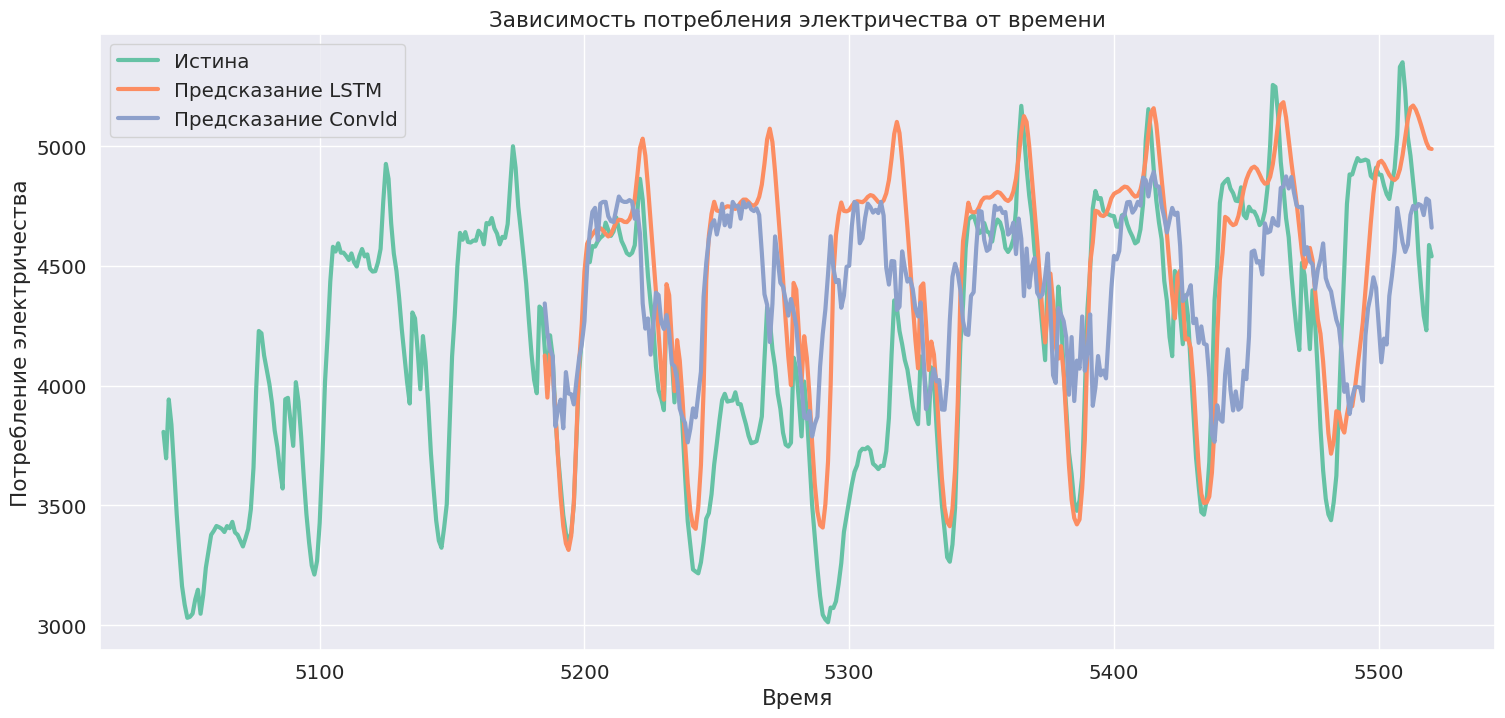

In [53]:
show_from = 48*7*15
lw = 3
plt.figure(figsize = (18, 8))
plt.title("Зависимость потребления электричества от времени")

plt.plot(
    df.index[show_from:], 
    df.Consumption[show_from:], 
    label="Истина", 
    lw=lw
)

plt.plot(
    df.index[-48*7:], 
    lstm_result[:, 0], 
    label='Предсказание LSTM', 
    lw=lw
)

plt.plot(
    df.index[-48*7:], 
    conv_result[:, 0], 
    label="Предсказание Convld", 
    lw=lw
)
plt.xlabel("Время")
plt.ylabel ('Потребление электричества')
plt.legend ()
plt.show()

# Практические рекомендации:

* CNN хорошо работает для анализа любого вида сигнальных данных в течение периода фиксированной длины, например, временных последовательностей показаний датчиков, аудиосигналы.
* Предсказание временных рядов очень чувствительно к выбору т, batch_size и других параметров. Поэтому их лучше подбирать по валидационному множеству.
* Подумайте, что вы хотите предсказывать. Не стоит при этом решать лишние задачи, которые добавят ошибку к результату. • Распишите все то, что известно в момент времени г. Все, что известно, может быть признаком этогмомента времени.
* Обращайте внимание на интервалы времени между замерами. Если они сильно отличаются, стоит проводить дополнительную
обработку данных.
* Можно предобучить модели на искусственно сгенерированных временных рядах, это может улучшить качество.

### Статьи, которые можно почитать:
* https://arxiv.org/pdf/1904.12546.pdf
* https://arxiv.org/pdf/1707.01836.pdf
* https://arxiv.org/pdf/1809.04356.pdf
* https://arxiv.org/pdf/1701.01887.pdf